### Overview:
In this analysis, we will explore the process of analyzing various movie datasets to identify trends and patterns in the types of films currently doing well at the box office. The ultimate goal is to provide actionable insights that can be used to guide decision-making at Microsoft's new movie studio.


###  Importing Libraries and Loading Data
To start, we need to import the necessary libraries and load the data into data frames. In this analysis, we will use pandas and matplotlib libraries.

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3

# Load data from csv files
movies = pd.read_csv('zippedData/bom.movie_gross.csv')
ratings = pd.read_csv('zippedData/rt.movie_info.tsv', sep='\t')
budgets = pd.read_csv('zippedData/tn.movie_budgets.csv')
popular_movies = pd.read_csv('zippedData/tmdb.movies.csv', index_col = 0)

In [214]:
# Analyze the table movies
movies.head(2)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010


In [215]:
# check if we have null values
movies.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [216]:
#Replace the null values in studio gross column with mode since it has categorical values
mode_studio = movies.studio.mode()[0]
movies.studio.fillna(mode_studio, inplace = True)

#Replace the null values in domestic gross column with mean
mean_domestic_gross = movies.domestic_gross.mean()
movies.domestic_gross.fillna(mean_domestic_gross, inplace = True)

#drop column foreign gross since it has more missing values;
movies.drop('foreign_gross', axis = 1).head()

,title,studio,domestic_gross,year
0,Toy Story 3,BV,415000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,2010
3,Inception,WB,292600000.0,2010
4,Shrek Forever After,P/DW,238700000.0,2010


In [217]:
# Order the studios from the one that has the highest domestic gross
movies.sort_values(by='domestic_gross', ascending=False, inplace=True)
domestic_gross_by_studio  = movies.groupby(['studio'])['domestic_gross'].sum().sort_values(ascending=False).head()
domestic_gross_by_studio

studio
BV      1.841903e+10
Uni.    1.290239e+10
WB      1.216805e+10
Fox     1.094950e+10
Sony    8.488429e+09
Name: domestic_gross, dtype: float64

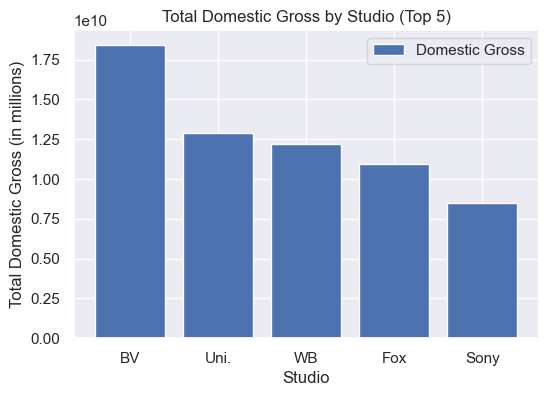

In [218]:
# Visualizing the first five studios with the highest domestic gross
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(domestic_gross_by_studio.index, domestic_gross_by_studio.values, label = "Domestic Gross")

# Set the title and axis labels
ax.set_title('Total Domestic Gross by Studio (Top 5)')
ax.set_xlabel('Studio')
ax.set_ylabel('Total Domestic Gross (in millions)')
ax.legend();

### Analyze the ratings table

In [219]:
budgets.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


In [220]:
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


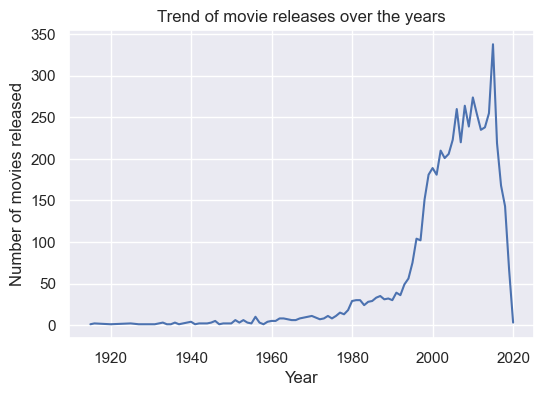

In [221]:
# Analyze the trend of movie releases over the years
budgets['release_date'] = pd.to_datetime(budgets['release_date'])
budgets['year'] = budgets['release_date'].dt.year
yearly_releases = budgets.groupby('year').size()

sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(6,4)})
sns.lineplot(x=yearly_releases.index, y=yearly_releases.values)
plt.xlabel('Year')
plt.ylabel('Number of movies released')
plt.title('Trend of movie releases over the years');

### Typecast the columns production budget, domestic, foreign and worlwide
To be able to use these columns we must convert the values into floats


In [222]:
budgets['production_budget'] = budgets['production_budget'].str.replace('$', '').str.replace(',', '').astype(float)
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$', '').str.replace(',', '').astype(float)
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(float)

C:\Users\Daniel Ekale\AppData\Local\Temp\ipykernel_1872\1283533052.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  budgets['production_budget'] = budgets['production_budget'].str.replace('$', '').str.replace(',', '').astype(float)
C:\Users\Daniel Ekale\AppData\Local\Temp\ipykernel_1872\1283533052.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$', '').str.replace(',', '').astype(float)
C:\Users\Daniel Ekale\AppData\Local\Temp\ipykernel_1872\1283533052.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions wil

### Generate a correlation matrix for the columns 'production_budget', 'domestic_gross', 'worldwide_gross'

In [223]:
correlation_matrix = budgets[['production_budget', 'domestic_gross', 'worldwide_gross']].astype(float).corr()
print(correlation_matrix)

                   production_budget  domestic_gross  worldwide_gross
production_budget           1.000000        0.685682         0.748306
domestic_gross              0.685682        1.000000         0.938853
worldwide_gross             0.748306        0.938853         1.000000


In [224]:
# select rating, genre and box office column to see which one had the highest revenue at the box office
top_movies = ratings[['rating','genre','box_office']].sort_values(by='box_office', ascending = False).head()
top_movies

,rating,genre,box_office
16,R,Drama,"99,165,609"
1510,PG-13,Action and Adventure|Comedy|Science Fiction an...,"98,000,000"
207,R,Action and Adventure|Drama|Western,"976,847"
1469,R,Animation|Comedy,"97,661,826"
1323,G,Comedy|Kids and Family,"95,111,012"


In [225]:
popular_movies.head(2)

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610


In [226]:
popular_movies[['genre_ids', 'popularity', 'release_date','vote_average', 'vote_count']].sort_values('popularity', ascending = False).head()

,genre_ids,popularity,release_date,vote_average,vote_count
23811,"[12, 28, 14]",80.773,2018-04-27,8.3,13948
11019,"[28, 53]",78.123,2014-10-24,7.2,10081
23812,"[28, 12, 16, 878, 35]",60.534,2018-12-14,8.4,4048
11020,"[28, 12, 14]",53.783,2014-12-17,7.3,8392
5179,"[878, 28, 12]",50.289,2012-05-04,7.6,19673


In [227]:
# creating a connection to im database
conn = sqlite3.connect('zippedData/im.db')

In [228]:
# checking all the tables in the database
table_name_query = """SELECT name 
                      AS 'Table Names' 
                      FROM sqlite_master 
                      WHERE type='table';"""

pd.read_sql(table_name_query, conn)

,Table Names
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


### Data Understanding
To begin my analysis, I first had to understand the data provided. The data came from several sources and included various file formats. The data sources were:
1. Box Office Mojo
2. IMDB
3. Rotten Tomatoes
4. TheMovieDB
5. The Numbers

The data included information on movie titles, release dates, genres, production companies, budgets, and box office revenue. Some of the data was provided in a SQLite database, while other data was in CSV or TSV file formats.

In [229]:
movies.head(2)

,title,studio,domestic_gross,foreign_gross,year
1872,Star Wars: The Force Awakens,BV,936700000.0,"1,131.6",2015
3080,Black Panther,BV,700100000.0,646900000,2018


In [230]:
ratings.head(2)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One


In [231]:
# we check the null values in the dataset movies
movies.isna().sum()

title                0
studio               0
domestic_gross       0
foreign_gross     1350
year                 0
dtype: int64

In [232]:
# We now frop the null values and replace our dataframe movies
movies.drop

<bound method DataFrame.drop of                              title studio  domestic_gross foreign_gross  year
1872  Star Wars: The Force Awakens     BV     936700000.0       1,131.6  2015
3080                 Black Panther     BV     700100000.0     646900000  2018
3079        Avengers: Infinity War     BV     678800000.0       1,369.5  2018
1873                Jurassic World   Uni.     652300000.0       1,019.4  2015
727          Marvel's The Avengers     BV     623400000.0     895500000  2012
...                            ...    ...             ...           ...   ...
3078                          2:22  Magn.           400.0           NaN  2017
2321               The Chambermaid     FM           300.0           NaN  2015
2756         News From Planet Mars     KL           300.0           NaN  2016
2757                       Satanic  Magn.           300.0           NaN  2016
1476                    Storage 24  Magn.           100.0           NaN  2013

[3387 rows x 5 columns]>

### Identifying Most Successful Genres
To identify the most successful genres, we need to merge the movies and ratings data frames and group by genre to calculate the average box office revenue per genre.

In [233]:
# Merge the movies and ratings data frames
movies_ratings = pd.merge(movies, ratings, left_on='title', right_on='title')

# Group by genre and calculate average box office revenue
genres = movies_ratings.groupby('genre')['domestic_gross'].mean().sort_values(ascending=False)


KeyError: 'title'